## Initialization

In [1]:
import os
import grasp
import numpy as np
import pandas as pd
from astropy import units as u
from matplotlib import pyplot as plt
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')

try:
    device_name = os.getenv('COMPUTERNAME')
    if device_name == 'DESKTOP-Work':
        tn1 = '20250506_170539'
        tn2 = '20250506_170541'
        tn3 = '20250515_193141'
        acs = grasp.load_data(tn = tn1)
        pcs = grasp.load_data(tn = tn2)
        fas = grasp.load_data(tn = tn3)
    elif device_name == 'LAPTOP-Work':
        tn1 = '20250401_164228'
        tn2 = '20250401_164231'
        tn3 = '20250515_094935'
        pcs = grasp.load_data(tn = tn1, data_format='ascii.tab', file_format='.txt')
        acs = grasp.load_data(tn = tn2, data_format='ascii.tab', file_format='.txt')
        fas = grasp.load_data(tn = tn3)
    else:
        raise EnvironmentError("Unknown device name")
    acs.gc = pcs.gc = fas.gc = gc
except FileNotFoundError as e:
    print(e)
    astrometry_query = "SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, \
                        radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND abs(parallax_error/parallax)<0.50\
                        AND abs(pmra_error/pmra)<0.30 \
                        AND abs(pmdec_error/pmdec)<0.30 \
                        AND pmra IS NOT NULL AND abs(pmra)>0 \
                        AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.214805 AND -17.807517"
    
    photometry_query = "SELECT source_id, ra, ra_error, dec_error, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, \
                        bp_rp, phot_g_mean_mag, phot_bp_rp_excess_factor, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND ruwe < 1.15 \
                        AND phot_g_mean_mag > 11 \
                        AND astrometric_excess_noise_sig < 2 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.2148 AND -17.807517"
    acs = dr3.free_query(astrometry_query, save=True)
    acs = grasp.Sample(acs, gc)
    pcs = dr3.free_query(photometry_query, save=True)
    pcs = grasp.Sample(pcs, gc)
    fas = dr3.get_astrometry(1., 'ngc6121', save=True)
    print("\nWARNING! Remember to updates tn after running the new query!!!")



            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:           GAIA QUERY MODULE
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;             INITIALIZED
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
          ::::::::::;;;::...
            ....::::.....

Initialized with Gaia table: 'gaiadr3.gaia_source'
Not a Cluster: no model available
Not a Cluster: no model available


In [2]:
aps = acs.join(pcs)
aps.gc.dist = 1851 * u.pc # Baumgardt, Vasiliev: 2021 # pc
f = grasp.load_base_formulary()
aps.info()

<Sample length=1014>
          name            dtype     class     n_bad
------------------------ ------- ------------ -----
               SOURCE_ID   int64       Column     0
                      ra float64       Column     0
                ra_error float32       Column     0
                     dec float64       Column     0
               dec_error float32       Column     0
                parallax float64       Column     0
          parallax_error float32       Column     0
                    pmra float64       Column     0
              pmra_error float32       Column     0
                   pmdec float64       Column     0
             pmdec_error float32       Column     0
         radial_velocity float32 MaskedColumn   923
   radial_velocity_error float32 MaskedColumn   923
                   bp_rp float32 MaskedColumn    31
         phot_g_mean_mag float32 MaskedColumn     1
        phot_bp_mean_mag float32 MaskedColumn   118
        phot_rp_mean_mag float32 MaskedColu

# MachineLearning

## Golden-Sample XDGMM

### PMRA ($\mu_\alpha$) 
KDE mean

Correctly imported `minpack.lm`.


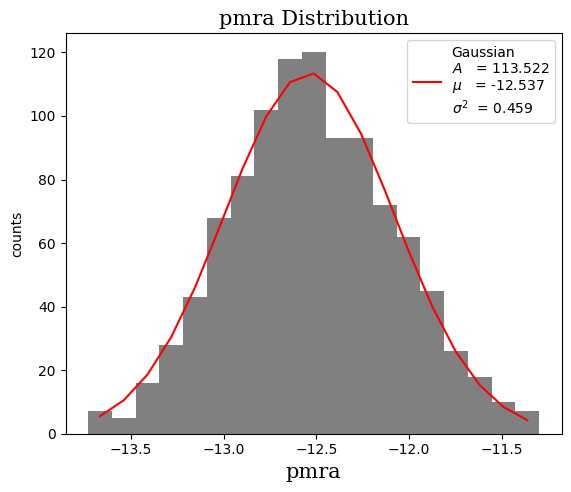

pmra_mean = -12.5372


In [6]:
pmra = aps.pmra
pmra_kde = grasp.plots.histogram(pmra, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmra_mean = pmra_kde[1]
print(f"{pmra_mean = :.4f}")

### PMDEC ($\mu_{\delta^*}$) 
KDE mean

Correctly imported `minpack.lm`.


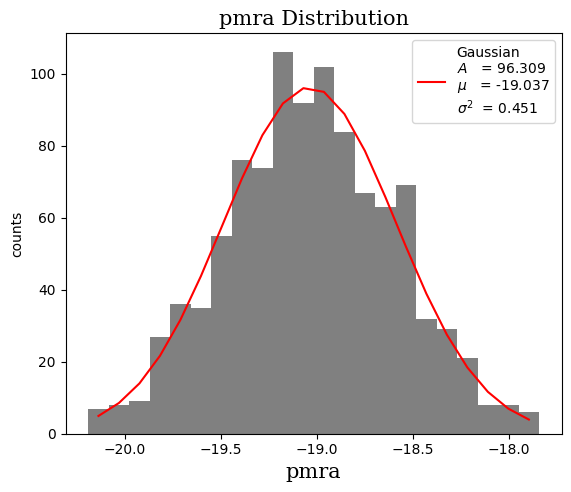

pmdec_mean = -19.0371


In [7]:
pmdec = aps.pmdec
pmdec_kde = grasp.plots.histogram(pmdec, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmdec_mean = pmdec_kde[1]
print(f"{pmdec_mean = :.4f}")

### XDGMM (eXtreme Deconvolution Gaussian Mixture Model)

For cluster parameters estimation from subsample, to be checked with PM regression and with clustering classification

In [8]:
ra, dec = ((aps.ra * u.deg).to(u.rad).value, (aps.dec * u.deg).to(u.rad).value)
f.substitute(
    "Angular separation",
    {"alpha_{0}": aps.gc.ra.to(u.rad).value, "delta_{0}": aps.gc.dec.to(u.rad).value},
)
theta_GC = f.compute(
    "Angular Separation",
    data={"alpha_{1}": ra, "delta_{1}": dec},
    errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error},
    asarray=True,
)

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Errors:       [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations: [rho_alpha_{1}_delta_{1}]
------------------------------
Errors:
Computation using all 16 cores.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as ac, mean_absolute_error as mea, mean_squared_error as mse

data = np.array([aps.SOURCE_ID, aps.pmra, aps.pmdec, theta_GC[0]]).T
errors = np.array([aps.SOURCE_ID, aps.pmra_error, aps.pmdec_error, theta_GC[1]]).T
correlation = aps.pmra_pmdec_corr.value

In [10]:
X_train, X_test, err_train, err_test, corr_train, corr_test = train_test_split(data, errors, correlation, test_size=0.2)
if all(X_train[:,0] == err_train[:,0]) and all(X_test[:,0] == err_test[:,0]):
    print("Data and errors are aligned.\nRemoving source_id column...\n")
    err_train = np.delete(err_train, 0, axis=1)
    err_test = np.delete(err_test, 0, axis=1)
    X_train = np.delete(X_train, 0, axis=1)
    X_test = np.delete(X_test, 0, axis=1)
else:
    print("Data and errors are not aligned. Exiting...")
    exit(1)
print(f"{X_train.shape = :}")
print(f"{X_test.shape = :}\n")
print(f"{err_train.shape = :}")
print(f"{err_test.shape = :}")
print(f"\n{corr_train.shape = :}")
print(f"{corr_test.shape = :}\n")

Data and errors are aligned.
Removing source_id column...

X_train.shape = (811, 3)
X_test.shape = (203, 3)

err_train.shape = (811, 3)
err_test.shape = (203, 3)

corr_train.shape = (811,)
corr_test.shape = (203,)



In [11]:
train_cov = grasp.stats._construct_covariance_matrices(err_train, {(0,1): corr_train})
test_cov = grasp.stats._construct_covariance_matrices(err_test, {(0,1): corr_test})
print(f"{train_cov.shape = :}")
print(f"{test_cov.shape = :}\n")

train_cov.shape = (811, 3, 3)
test_cov.shape = (203, 3, 3)



In [12]:
model = grasp.stats.XD_estimator(data=X_train, errors=err_train, correlations={(0,1): corr_train}, n_components=1)

In [13]:
xdgmm_pmra_mean, xdgmm_pmdec_mean, _ = tuple([mu[0] for mu in model.mu.T])
print(f"{pmra_mean = :.3f} mas/yr  ;  {pmdec_mean = :.3f} mas/yr\n")
print(f"{xdgmm_pmra_mean = :.3f} mas/yr  ;  {xdgmm_pmdec_mean = :.3f} mas/yr")

pmra_mean = -12.537 mas/yr  ;  pmdec_mean = -19.037 mas/yr

xdgmm_pmra_mean = -12.524 mas/yr  ;  xdgmm_pmdec_mean = -19.015 mas/yr


In [14]:
print(f"{xdgmm_pmra_mean/pmra_mean*100 = :.3f} %")
print(f"{xdgmm_pmdec_mean/pmdec_mean*100 = :.3f} %")

xdgmm_pmra_mean/pmra_mean*100 = 99.894 %
xdgmm_pmdec_mean/pmdec_mean*100 = 99.885 %


## GMM on Full Sample

### Feature Engeneering

In [15]:
fas = dr3.free_gc_query(
    1.2,
    'ngc6121', 
    data = 'source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error,ra_dec_corr,pmra_pmdec_corr',
    save=True
)
Ni = len(fas)
fas.join(aps, keep='left_only', inplace=True)
Nf = len(fas)
assert Ni-Nf == len(aps), f"Number of sources in fas ({Ni-Nf}) is not equal to the number of sources in aps ({len(aps)})"

fas.drop_columns(
    [
        "radial_velocity",
        "radial_velocity_error",
        "bp_rp",
        "phot_g_mean_mag",
        "teff_gspphot",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "phot_bp_rp_excess_factor"
    ]
)

fas.dropna()

Key error: 'Scan_Info'
Key error: 'Scan_Info'
Key error: 'Scan_Info'
Key error: 'Scan_Info'
Key error: 'Scan_Info'
Found data with the same conditions for object NGC6121 in
20250515_193141.
Loading it...
Sample number of sources: 314663


Correctly imported `minpack.lm`.


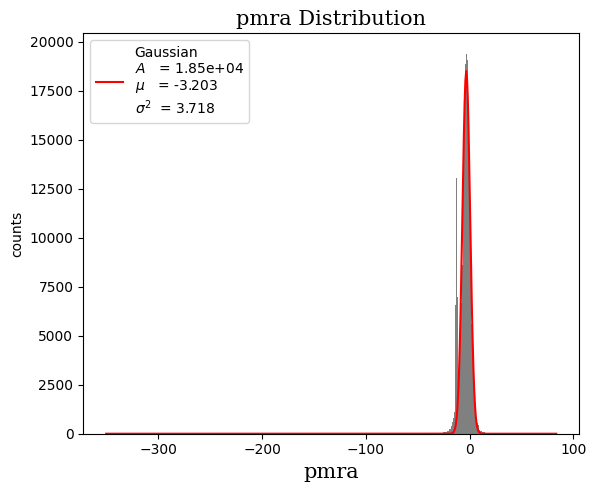

Correctly imported `minpack.lm`.


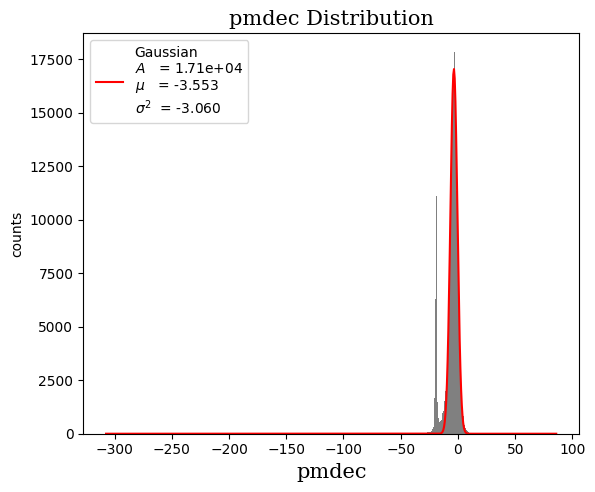

In [16]:
pmra_dist = grasp.plots.histogram(fas['pmra'].value, bins='knuth', kde=True ,xlabel='pmra', out=True)
pmdec_dits = grasp.plots.histogram(fas['pmdec'].value, bins='knuth', kde=True ,xlabel='pmdec', out=True)

Removing extreme outliers

In [17]:
fas.apply_conditions(
    conditions={
        "pmra": f"<50",
        "pmra": f">-50",
        "pmdec":f"<50",
        "pmdec":f">-50",
    },
    inplace=True,
)

Data sample for cluster NGC6121

 Data Columns:                                              
-------------------------------------------------------------------------
 source_id         ra     ra_error     dec     dec_error     parallax
 parallax_error    pmra   pmra_error   pmdec   pmdec_error   ra_dec_corr
 pmra_pmdec_corr                                            


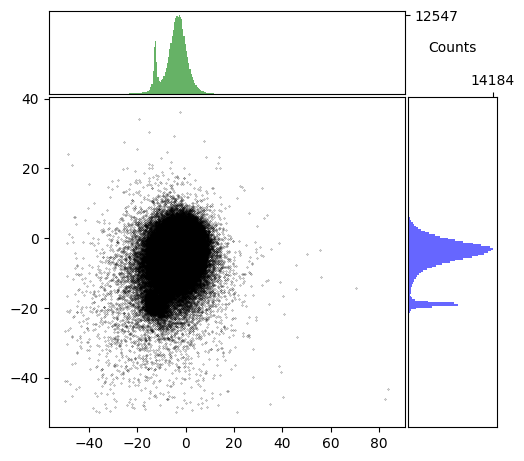

In [18]:
grasp.plots.doubleHistScatter(fas.pmra, fas.pmdec, size=0.05, alpha=0.85)

In [19]:
#f.var_order('angular separation')
fas['ang_sep'], fas['ang_sep_error'] = f.compute('angular separation',
          data={'alpha_{1}': (fas.ra*u.deg).to(u.rad).value, 'delta_{1}': (fas.dec*u.deg).to(u.rad).value}, 
          errors={"epsilon_alpha_{1}": (fas.ra_error*u.deg).to(u.rad).value, "epsilon_delta_{1}": (fas.dec_error*u.deg).to(u.rad).value}, 
          corrs={'rho_alpha_{1}_delta_{1}': fas.ra_dec_corr},
          asarray=True)

fas['ang_sep_over_error'] = fas['ang_sep_error'] / fas['ang_sep']
fas.apply_conditions('ang_sep_over_error < 3.0', inplace=True)

fas[['ang_sep', 'ang_sep_error', 'ang_sep_over_error']].describe()

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Errors:       [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations: [rho_alpha_{1}_delta_{1}]
------------------------------
Errors:
Data sample for cluster NGC6121

 Data Columns:                                                       
------------------------------------------------------------------------------------
 source_id            ra               ra_error          dec          dec_error
 parallax             parallax_error   pmra              pmra_error   pmdec
 pmdec_error          ra_dec_corr      pmra_pmdec_corr   ang_sep      ang_sep_error
 ang_sep_over_error                                                  


,ang_sep,ang_sep_error,ang_sep_over_error
count,238681.000000,238681.000000,238681.000000
mean,0.012920,0.006038,0.578788
std,0.005458,0.005173,0.549468
min,0.000080,0.000103,0.005823
25%,0.009033,0.002201,0.195974
50%,0.013844,0.004622,0.404562
75%,0.017409,0.008390,0.768054
max,0.020944,0.052887,2.999901


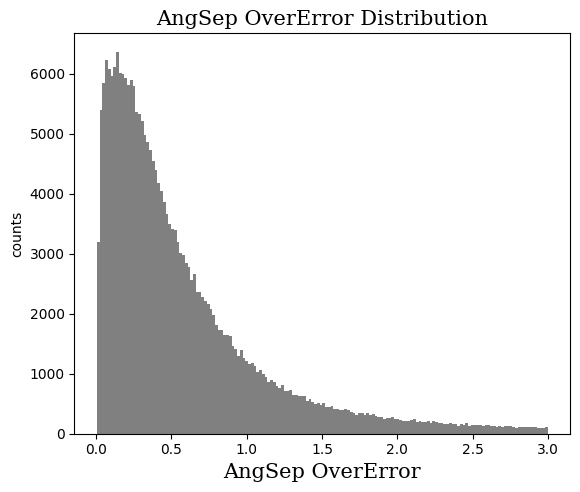

In [22]:
grasp.plots.histogram(fas['ang_sep_over_error'], bins='knuth', xlabel='AngSep OverError', out=False)

### Model1: GMM with  $\,\forall \bar{\omega} \in \mathcal{R}$

In [31]:
data = fas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
# errors = fas[['ra_error','dec_error','pmra_error','pmdec_error','parallax_error']].to_numpy()
# correlation = fas['pmra_pmdec_corr']

# X_train, X_test, err_train, err_test, corr_train, corr_test = train_test_split(data, errors, correlation, test_size=0.2)
X_train, X_test = train_test_split(data, test_size=0.33)

print(f"{X_train.shape = :}")
print(f"{X_test.shape = :}\n")
# print(f"{err_train.shape = :}")
# print(f"{err_test.shape = :}")
# print(f"\n{corr_train.shape = :}")
# print(f"{corr_test.shape = :}\n")

X_train.shape = (159916, 5)
X_test.shape = (78765, 5)



In [32]:
model1 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%


Text(0.5, 1.0, 'Model1: G=3 with full parallaxes')

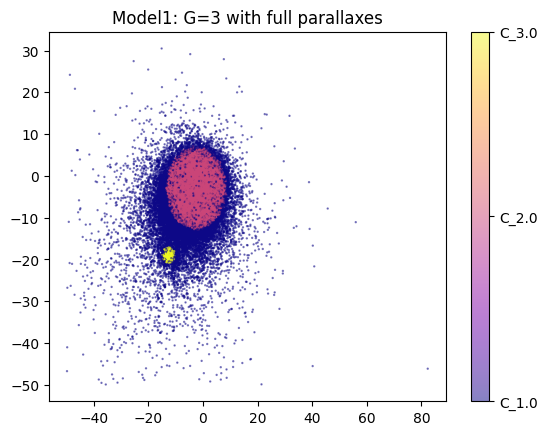

In [33]:
plt.scatter(X_train[:,2], X_train[:,3], c=model1.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model1.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model1.train_classification['classification'])])
plt.title('Model1: G=3 with full parallaxes')

In [34]:
pd.DataFrame(data=model1.train_classification['classification']).value_counts()

0  
2.0    125929
1.0     22600
3.0     11387
Name: count, dtype: int64

In [35]:
model1_parameters = pd.DataFrame(data=model1.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model1_parameters)

            ra        dec       pmra      pmdec  parallax
G1  245.979363 -26.578662  -5.336445  -7.145485  0.640285
G2  246.026429 -26.597958  -2.975833  -3.515095  0.288033
G3  245.897896 -26.526760 -12.511635 -19.016332  0.528522


In [36]:
predictions = model1.predict(X_test)

Correctly imported `mclust`.


Text(0.5, 1.0, 'Model1 Test Set')

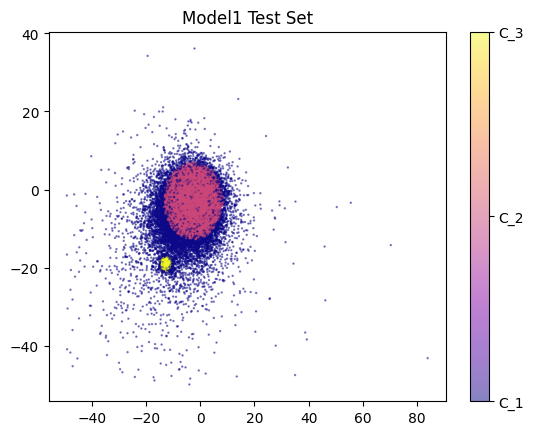

In [37]:
plt.scatter(X_test[:,2], X_test[:,3], c=predictions['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions['classification'])])
plt.title('Model1 Test Set')

### Model2: GMM with $\,\forall\bar{\omega}\in\mathcal{R}^+$

In [23]:
pfas = fas.apply_conditions('parallax>0', inplace=False)
print(f"Parallax cleaned sample is {len(pfas)/len(fas)*100:.2f} % of the original sample")

Parallax cleaned sample is 75.48 % of the original sample


In [24]:
data2 = pfas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
X_train2, X_test2 = train_test_split(data2, test_size=0.33)

print(f"{X_train2.shape = :}")
print(f"{X_test2.shape = :}\n")

X_train2.shape = (120709, 5)
X_test2.shape = (59454, 5)



In [25]:
model2 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%


0  
2.0    89591
1.0    20232
3.0    10886
Name: count, dtype: int64

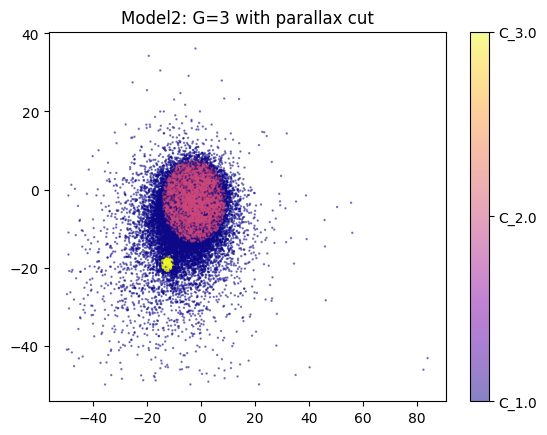

In [26]:
plt.scatter(X_train2[:,2], X_train2[:,3], c=model2.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model2.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model2.train_classification['classification'])])
plt.title('Model2: G=3 with parallax cut')

pd.DataFrame(data=model2.train_classification['classification']).value_counts()

In [27]:
model2_parameters = pd.DataFrame(data=model2.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model2_parameters)

            ra        dec       pmra      pmdec  parallax
G1  245.973920 -26.577428  -5.188835  -7.207378  1.594888
G2  246.017479 -26.597250  -2.959538  -3.503125  0.469429
G3  245.898689 -26.528047 -12.517636 -19.013488  0.548593


In [28]:
predictions2 = model2.predict(X_test2)

Correctly imported `mclust`.


Text(0.5, 1.0, 'Model2 Test Set')

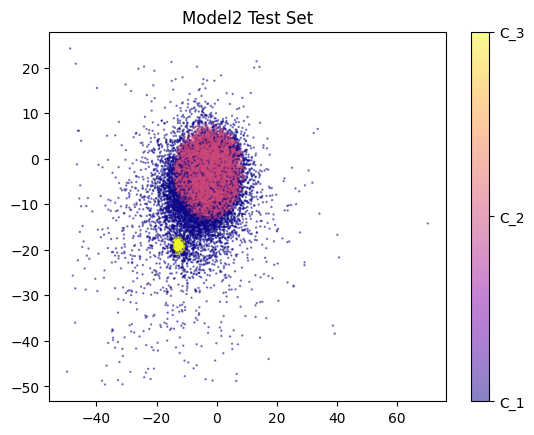

In [29]:
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions2['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions2['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions2['classification'])])
plt.title('Model2 Test Set')

### Model3: only 2 gaussian components with $\forall\bar{\omega}\in\mathcal{R}^+$

In [38]:
model3 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%


0  
1.0    109694
2.0     11015
Name: count, dtype: int64

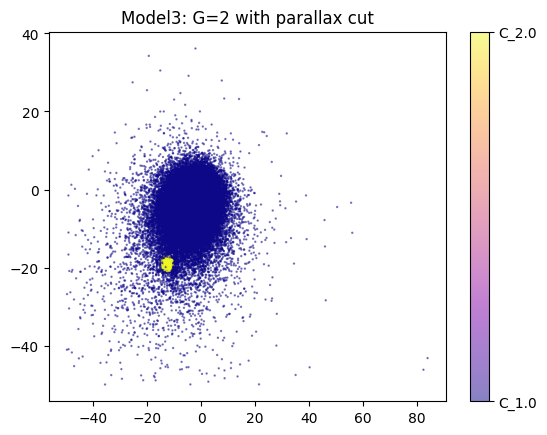

In [39]:
plt.scatter(X_train2[:,2], X_train2[:,3], c=model3.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model3.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model3.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model3.train_classification['classification']).value_counts()

In [40]:
predictions3 = model3.predict(X_test2)
model3_parameters = pd.DataFrame(data=model3.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model3_parameters)

Correctly imported `mclust`.
            ra        dec       pmra      pmdec  parallax
G1  246.008510 -26.593152  -3.414671  -4.260020  0.704825
G2  245.898544 -26.528335 -12.519273 -19.014633  0.554141


Text(0.5, 1.0, 'Model3 Test Set')

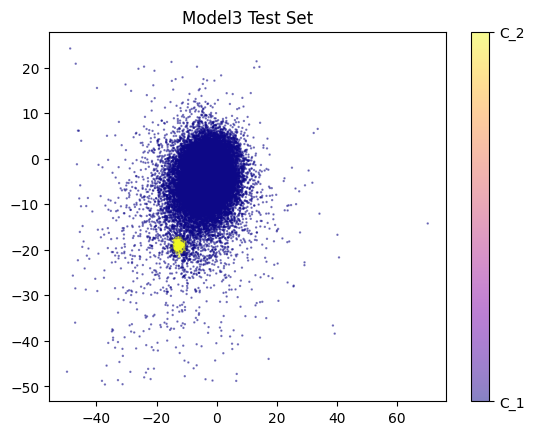

In [41]:
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions3['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions3['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions3['classification'])])
plt.title('Model3 Test Set')

### KFold Cross-Validation with GMM

In [ ]:
nfolds = 20
kfold_model = grasp.stats.kfold_gmm_estimator(
    data=data2,
    folds=nfolds,
    G=3,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Model's BIC Variance: 0.085 %


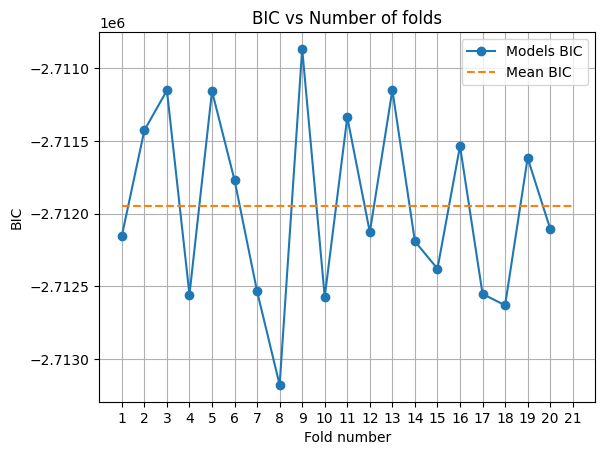

In [43]:
plt.plot(np.arange(1,nfolds+1), kfold_model.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfold_model.mean_bic,kfold_model.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfold_model.bics) - np.max(kfold_model.bics))/np.max(kfold_model.bics) * 100:.3f} %")

Try with 2 Cluster members

In [ ]:
nfolds = 20
kfold_model2 = grasp.stats.kfold_gmm_estimator(
    data=data2,
    folds=nfolds,
    G=2,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Model's BIC Variance: 0.128 %


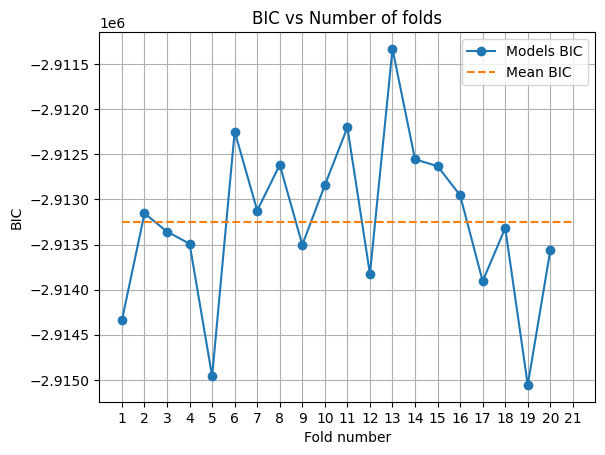

In [45]:
plt.plot(np.arange(1,nfolds+1), kfold_model2.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfold_model2.mean_bic,kfold_model2.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfold_model2.bics) - np.max(kfold_model2.bics))/np.max(kfold_model2.bics) * 100:.3f} %")

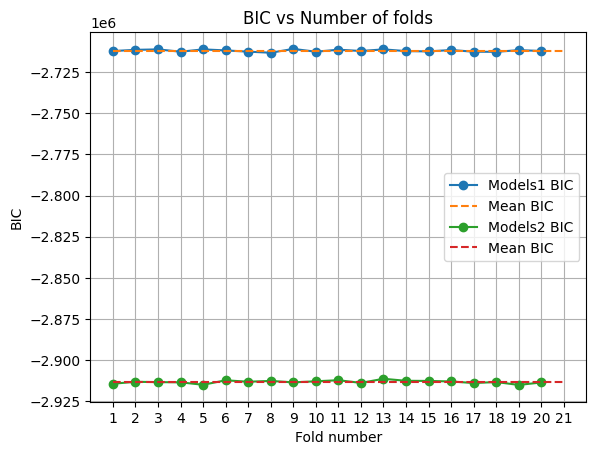

In [46]:
plt.plot(np.arange(1,nfolds+1), kfold_model.bics, '-o', label='Models1 BIC')
plt.plot([1,nfolds+1], [kfold_model.mean_bic,kfold_model.mean_bic], '--', label='Mean BIC')
plt.plot(np.arange(1,nfolds+1), kfold_model2.bics, '-o', label='Models2 BIC')
plt.plot([1,nfolds+1], [kfold_model2.mean_bic,kfold_model2.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

In [ ]:
best_model = kfold_model.best_model()
best_model2 = kfold_model2.best_model()

In [130]:
print(f"Best 3-G Model:\n {pd.DataFrame(best_model.coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best 2-G Model:\n{pd.DataFrame(best_model2.coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}")

Best 3-G Model:
            ra        dec       pmra      pmdec  parallax
0  245.978741 -26.575783  -5.232751  -7.173206  1.582505
1  246.018567 -26.598434  -2.952315  -3.507116  0.468302
2  245.898190 -26.526981 -12.513408 -19.013313  0.547181

Best 2-G Model:
           ra        dec       pmra      pmdec  parallax
0  246.010395 -26.593142  -3.426944  -4.265312  0.704859
1  245.898121 -26.527554 -12.515573 -19.014180  0.553556


Text(0.5, 1.0, 'Best Model: G=2 with parallax cut')

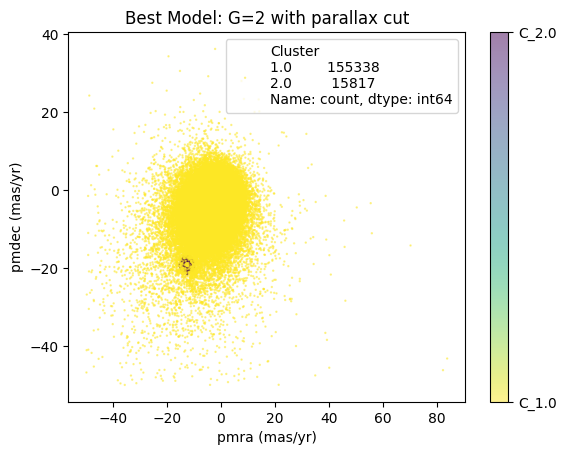

In [ ]:
bm2_data = best_model2.data

text = pd.DataFrame(data=best_model2.train_classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(bm2_data[:,2], bm2_data[:,3], c=best_model2.train_classification['classification'], cmap='viridis_r', s=0.5, alpha=0.5, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model2.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model2.train_classification['classification'])])
plt.legend(loc='best')
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('Best Model: G=2 with parallax cut')

Text(0.5, 1.0, 'Best Model: G=3 with parallax cut')

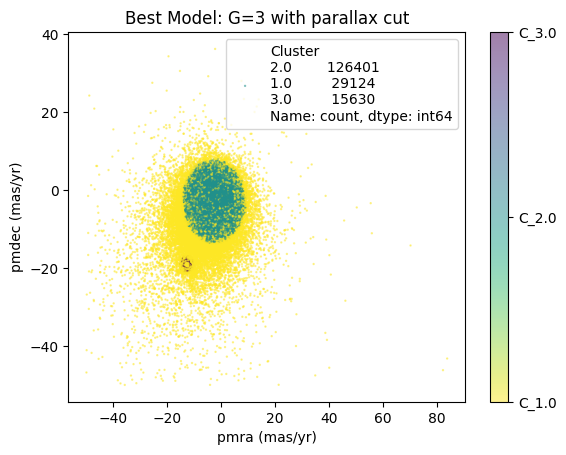

In [59]:
bm3_data = best_model.data

text = pd.DataFrame(data=best_model.train_classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(bm3_data[:,2], bm3_data[:,3], c=best_model.train_classification['classification'], cmap='viridis_r', s=0.5, alpha=0.5, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model.train_classification['classification'])])
plt.legend(loc='best')
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('Best Model: G=3 with parallax cut')

In [133]:
best_model.save_model(grasp.gpaths.CLUSTER_DATA_FOLDER('ngc6121')+'/BEST_3C_MODEL')
best_model2.save_model(grasp.gpaths.CLUSTER_DATA_FOLDER('ngc6121')+'/BEST_2C_MODEL')

Model saved to /home/pietrof/graspdata/query/NGC6121/BEST_3C_MODEL.rds
Model saved to /home/pietrof/graspdata/query/NGC6121/BEST_2C_MODEL.rds


### Try the predict on the Golden Sample

In [64]:
aps.drop_columns(
    [
        "radial_velocity",
        "radial_velocity_error",
        "bp_rp",
        "phot_g_mean_mag",
        "teff_gspphot",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "phot_bp_rp_excess_factor"
    ]
)
aps.info()

<Sample length=1014>
      name       dtype 
--------------- -------
      SOURCE_ID   int64
             ra float64
       ra_error float32
            dec float64
      dec_error float32
       parallax float64
 parallax_error float32
           pmra float64
     pmra_error float32
          pmdec float64
    pmdec_error float32
    ra_dec_corr float32
pmra_pmdec_corr float32
         _merge   str10


In [66]:
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])

_ = best_model2.predict(gs_data)
_ = best_model.predict(gs_data)

Correctly imported `mclust`.
Correctly imported `mclust`.


Text(0.5, 1.0, 'Best Model: G=3 with parallax cut')

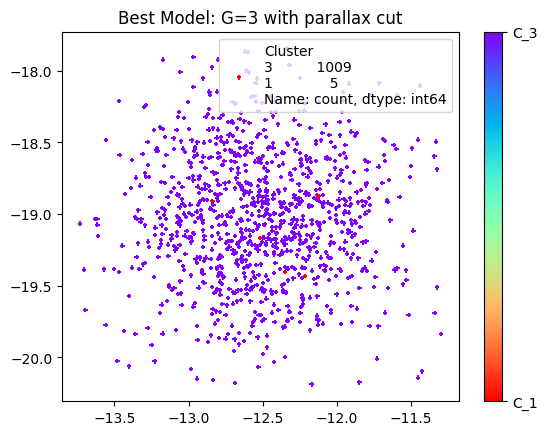

In [76]:
text = pd.DataFrame(data=best_model.classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(gs_data[:,2], gs_data[:,3], marker='+', c=best_model.classification['classification'], cmap='rainbow_r', s=10, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model.classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model.classification['classification'])])
plt.legend(loc='best')
plt.title('Best Model: G=3 with parallax cut')

Text(0.5, 1.0, 'Best Model: G=2 with parallax cut')

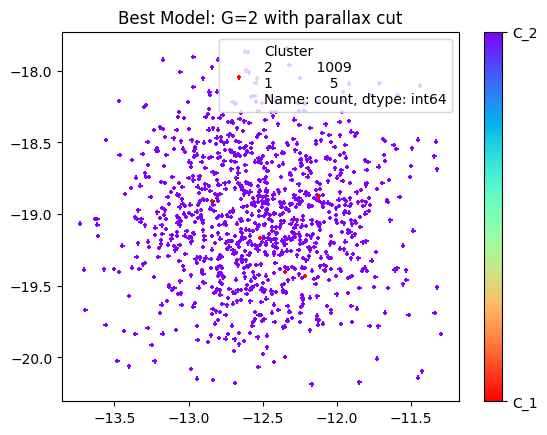

In [74]:
text = pd.DataFrame(data=best_model2.classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(gs_data[:,2], gs_data[:,3], marker='+', c=best_model2.classification['classification'], cmap='rainbow_r', s=10, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model2.classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model2.classification['classification'])])
plt.legend(loc='best')
plt.title('Best Model: G=2 with parallax cut')

In [80]:
print("Proper Motions RA")
print(f"{'kde':<10} {'xdgmm':<10} {'gmm2':<10} {'gmm3':<10}")
print(f"{pmra_mean:<10.3f} {xdgmm_pmra_mean:<10.3f} {best_model2.coeffs[1,2]:<10.3f} {best_model.coeffs[2,2]:<10.3f}\n")

print("Proper Motions DEC")
print(f"{'kde':<10} {'xdgmm':<10} {'gmm2':<10} {'gmm3':<10}")
print(f"{pmdec_mean:<10.3f} {xdgmm_pmdec_mean:<10.3f} {best_model2.coeffs[1,3]:<10.3f} {best_model.coeffs[2,3]:<10.3f}")

Proper Motions RA
kde        xdgmm      gmm2       gmm3      
-12.537    -12.524    -12.516    -12.513   

Proper Motions DEC
kde        xdgmm      gmm2       gmm3      
-19.037    -19.015    -19.014    -19.013   


In [82]:
pmrameans = np.array([pmra_mean, xdgmm_pmra_mean, best_model2.coeffs[1,2], best_model.coeffs[2,2]])
pmdecmeans = np.array([pmdec_mean, xdgmm_pmdec_mean, best_model2.coeffs[1,3], best_model.coeffs[2,3]])

print(f"pmra = {np.mean(pmrameans):.3f} $\\pm$ {np.std(pmrameans)/np.sqrt(len(pmrameans)):.3f}")
print(f"pmdec = {np.mean(pmdecmeans):.3f} $\\pm$ {np.std(pmdecmeans)/np.sqrt(len(pmdecmeans)):.3f}")

pmra = -12.523 $\pm$ 0.005
pmdec = -19.020 $\pm$ 0.005


In [85]:
print("Parallax")
print(f"{'gmm2':<10} {'gmm3':<10}")
print(f"{best_model2.coeffs[1,4]:<10.3f} {best_model.coeffs[2,4]:<10.3f}\n")

Parallax
gmm2       gmm3      
0.554      0.547     



In [87]:
parallaxmeans = np.array([best_model2.coeffs[1,4], best_model.coeffs[2,4]])
print(f"parallax = {np.mean(parallaxmeans):.3f} $\\pm$ {np.std(parallaxmeans)/np.sqrt(len(parallaxmeans)):.3f}")

parallax = 0.550 $\pm$ 0.002


# Riassunto

In [ ]:
best_model2 = grasp.GaussianMixtureModel.load_model(
    grasp.gpaths.CLUSTER_DATA_FOLDER('ngc6121')+'/BEST_2C_MODEL'
)

Utilizzando quaattro metodi diversi, si è calcolato il valore medio dei parametri per il cluster:

La media è stata calcolata con la formula classica, mentre l'uncertainty è stata stimata come 

$$\epsilon = \dfrac{\sigma}{\sqrt{N}}$$

> $ \big<\bar{\omega}\big> = 0.550 \pm 0.002 \, \mathrm{mas} $ (~ 1.81 Kpc)

> $ \big<\mu_\alpha\big> = -12.528 \pm 0.003 \, \mathrm{mas\cdot yr}^{-1}$

> $ \big<\mu_{\delta^*}\big> = -19.022 \pm 0.005 \, \mathrm{mas\cdot yr}^{-1}$


In [9]:
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])
_ = best_model2.predict(gs_data)
bm2_data = best_model2.data

gc.ra, gc.dec = (best_model2.coeffs[1,0], best_model2.coeffs[1,1])
print(gc.ra, gc.dec)

Correctly imported `mclust`.
245.89812095159058 -26.5275536664354


In [10]:
# mu_ra = np.array([np.mean(pmrameans), np.std(pmrameans)/np.sqrt(len(pmrameans))])
# mu_dec = np.array([np.mean(pmdecmeans), np.std(pmdecmeans)/np.sqrt(len(pmdecmeans))])
# px = np.array([np.mean(parallaxmeans), np.std(parallaxmeans)/np.sqrt(len(parallaxmeans))])

# Se si riparte direttamente da qui...
mu_ra = (-12.528 ,0.003)
mu_dec = (-19.022 ,0.005)
px = (0.0550 ,0.002)

gc.px = (px[0] * u.mas, px[1] * u.mas)
gc.pmra = (mu_ra[0] * u.mas / u.yr, mu_ra[1] * u.mas / u.yr)
gc.pmdec = (mu_dec[0] * u.mas / u.yr, mu_dec[1] * u.mas / u.yr)

print(f"{bm2_data.shape = } {gs_data.shape = }\n")
gc_data = bm2_data[np.array(best_model2.train_classification['classification']) == 2.]
gc2_data = gs_data[np.array(best_model2.classification['classification']) == 2.]
print(f"{gc_data.shape = } {gc2_data.shape = }")

predicted_sample = np.vstack((gc_data, gc2_data))

assert len(predicted_sample) == len(gc_data) + len(gc2_data), f"Predicted sample length {len(predicted_sample)} is not equal to the sum of gc_data {len(gc_data)} and gs_data {len(gc2_data)}"

print(f"\n{predicted_sample.shape = }")

bm2_data.shape = (171155, 5) gs_data.shape = (1014, 5)

gc_data.shape = (15817, 5) gc2_data.shape = (1009, 5)

predicted_sample.shape = (16826, 5)


In [11]:
gc_data = pd.DataFrame(data=predicted_sample, columns=['ra','dec','pmra','pmdec', 'parallax'])
gc_sample = grasp.Sample(gc_data, gc)
gc_sample.update_gc_params(ra=gc_sample.ra.mean(), dec=gc_sample.dec.mean())
print(gc_sample)


Harris Catalog 2010 edition Parameters

       Key                  Value
----------------------------------------
.id      Cluster Name       NGC6121
.ra      Position in sky    RA  245.90
.dec                        DEC -26.53
.dist    Distance           1851.00 pc
.w0      W0 Parameter       7.41
.logc    Concentration      logc=1.65
.cflag                      Collapsed -> False
.rc      Core radius        0.019 deg
.rh      Half-Light radius  0.072 deg
.rt      Tidal Radius       0.864 deg


Harris Catalog 2010 edition Parameters

       Key                  Value
----------------------------------------
.id      Cluster Name       NGC6121
.ra      Position in sky    RA  245.90
.dec                        DEC -26.53
.dist    Distance           1851.00 pc
.w0      W0 Parameter       7.41
.logc    Concentration      logc=1.65
.cflag                      Collapsed -> False
.rc      Core radius        0.019 deg
.rh      Half-Light radius  0.072 deg
.rt      Tidal Radius       0.864 d

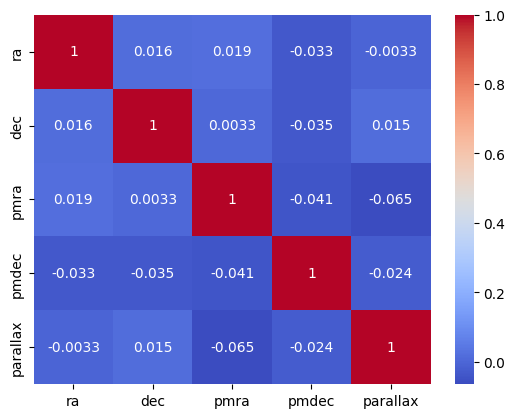

In [12]:
grasp.plots.seaborn(which='heatmap', data=gc_sample.to_pandas().corr(), annot=True, cmap='coolwarm', cbar=True)

In [13]:
ff = grasp.load_base_formulary()
ff.angular_separation

Eq(theta, 2*asin(sqrt((sin((alpha_{0} - alpha_{1})/2)**2*cos(delta_{1}))*cos(delta_{0}) + sin((delta_{0} - delta_{1})/2)**2)))

In [14]:
ff.substitute(
    "Angular separation",
    {"alpha_{0}": (gc_sample.gc.ra*u.deg).to(u.rad).value, "delta_{0}": (gc_sample.gc.dec*u.deg).to(u.rad).value}
)
ff.angular_separation

Eq(theta, 2*asin(sqrt(0.894722019329703*sin(alpha_{1}/2 - 2.14586776004826)**2*cos(delta_{1}) + sin(delta_{1}/2 + 0.231493958786548)**2)))

In [15]:
gc_sample['ang_sep'] = ff.compute(
    "Angular Separation",
    data={"alpha_{1}": (gc_sample.ra*u.deg).to(u.rad).value, "delta_{1}": (gc_sample.dec*u.deg).to(u.rad).value},
    #errors={"epsilon_alpha_{1}": (gc_sample.ra_error*u.deg).to(u.rad).value, "epsilon_delta_{1}": (gc_sample.dec_error*u.deg).to(u.rad).value},
    #corrs={'rho_alpha_{1}_delta_{1}': gc_sample.ra_dec_corr},
    asarray=True
)

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Computation using all 16 cores.


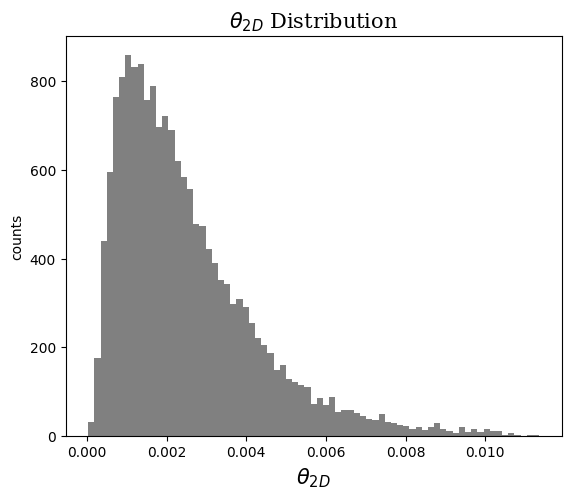

In [16]:
grasp.plots.histogram(gc_sample['ang_sep'], bins='knuth', xlabel=r'$\theta_{2D}$')

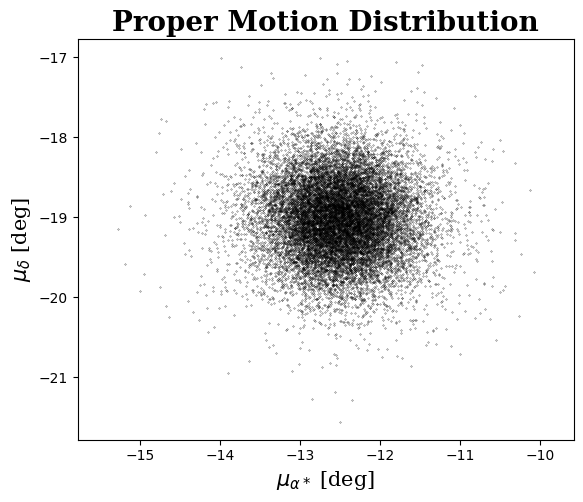

In [27]:
grasp.plots.properMotion(gc_sample, s=0.05, alpha=1)

### Calcolo delle distance: $r_{2D}$ and  $R_{3D}$

# Analisi Separazione Angolare

In [ ]:
grasp.plots.colorMagnitude(aps)

In [ ]:
grasp.plots.histogram(aps.parallax, bins='detailed')

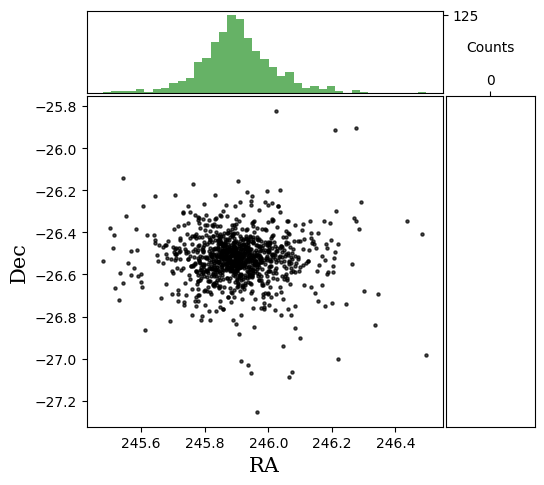

In [23]:
grasp.plots.doubleHistScatter(aps.ra, aps.dec, xlabel='RA', ylabel='Dec')

## Angular Separation Analysis

The `Great Circle` formula versus the `Vincenty Formula` for the computation of distances on a sphere

### $\theta_V$ vs $\theta_{GC}$ vs $\theta_{G}$

In [ ]:
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.to(u.rad).value, 'delta_{0}':aps.gc.dec.to(u.rad).value})

from sympy import atan2
atan_arg_1 = 'sqrt((cos(delta_1) * sin((alpha_0 - alpha_1)/2))**2 + (cos(delta_0)*sin(delta_1) - sin(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2 ))**2)'
atan_arg_2 = '(sin(delta_0)*sin(delta_1) + cos(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2))'
atan = atan2(atan_arg_1, atan_arg_2)
f.add_formula('Vincenty angsep', atan)
f.substitute('Vincenty angsep', {'alpha_0': aps.gc.ra.to(u.rad).value, 'delta_0':aps.gc.dec.to(u.rad).value})


f.angular_separation

In [ ]:
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.to(u.rad).value, 'delta_{0}':aps.gc.dec.to(u.rad).value})
theta_GC = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error}, asarray=True)

In [ ]:
f['Vincenty angsep']

In [ ]:
f.var_order('Angular Separation')
print('')
f.var_order('Vincenty angsep')

In [ ]:
ra, dec = ((aps.ra * u.deg).to(u.rad).value, (aps.dec * u.deg).to(u.rad).value)
print("Great Circle Distance computation\n")
theta_GC = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error}, asarray=True)
print("\nVincenty Distance computation\n")
theta_V = f.compute('Vincenty angsep', data={'alpha_1': ra, 'delta_1': dec}, asarray=True)

grasp.plots.doubleHistScatter(theta_V, theta_GC[0], xlabel='Vincenty Formula', ylabel='Angular Separation')

In [ ]:
t_ratio = theta_V/theta_GC[0]
err_t = (1-t_ratio) * 100
out = grasp.plots.histogram(err_t, bins='knuth', kde=True, kde_kind='lorentzian', xlabel=r'$\theta_V\,/\,\theta_GC$', out=True)
fit = out['kde']
print(f"A = {fit[0]:.2f}  ;  lambda = {fit[1]:.2f}")

### ADQL computed Angular Separation : $\theta_{G}$

Validated! <br>
It is shown how the angular separation computed from the ADQL language corresponds to the
Great Circle formula used by the GRASP package.

In [ ]:
query1: str = "SELECT source_id, DISTANCE(245.897,-26.526, ra, dec) AS ang_sep \
    FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
    AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
    AND abs(parallax_error/parallax)<0.50\
    AND abs(pmra_error/pmra)<0.30 \
    AND abs(pmdec_error/pmdec)<0.30 \
    AND pmra IS NOT NULL AND abs(pmra)>0 \
    AND pmdec IS NOT NULL AND abs(pmdec)>0 \
    AND pmra BETWEEN -13.742720 AND -11.295338 \
    AND pmdec BETWEEN -20.214805 AND -17.807517"

query2: str = "SELECT source_id, DISTANCE(245.897,-26.526, ra, dec) AS ang_sep  \
    FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
    AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
    AND ruwe < 1.15 \
    AND phot_g_mean_mag > 11 \
    AND astrometric_excess_noise_sig < 2 \
    AND pmra BETWEEN -13.742720 AND -11.295338 \
    AND pmdec BETWEEN -20.2148 AND -17.807517"

acs2 = grasp.Sample(dr3.free_query(query1), gc='ngc6121')
pcs2 = grasp.Sample(dr3.free_query(query2), gc='ngc6121')

In [ ]:
aps2 = acs2.join(pcs2)
aps2.gc.dist = 1851 * u.pc
aps2.info()

In [ ]:
theta_G = (aps2.ang_sep*u.deg).to(u.rad).value
grasp.plots.doubleHistScatter(theta_GC[0], theta_G, bins='knuth', xlabel=r"$\theta_GC$", ylabel=r"$\theta_G$")

### $r_{2D}(\theta_V)$ vs $r_{2D}(\theta_{GC})$

In [ ]:
f.substitute('radial_distance_2d', {'r_{c}': aps.gc.dist.value})
f.radial_distance_2d

In [ ]:
f.var_order('radial_distance_2d')

In [ ]:
print(r'Computation using $\theta_{GC}$')
r2d_GC = f.compute('radial_distance_2d', data={'theta': theta_GC[0]}, errors = {'epsilon_theta': theta_GC[1]}, asarray=True) # Great Circle
print('')
print(r'Computation using $\theta_{V}$')
r2d_V = f.compute('radial_distance_2d', data={'theta': theta_V}, asarray=True) # Vincenty Formula

r_ratio = r2d_V/r2d_GC[0]

In [ ]:
grasp.plots.doubleHistScatter(r2d_V, r2d_GC[0], xlabel=r'$r_{2d}(\theta_{V})$ [pc]', ylabel=r'$r_{2d}(\theta_{GC})$ [pc]')

In [ ]:
grasp.plots.histogram(1-r_ratio[r_ratio<400], kde=True, kde_kind='lorentzian', xlabel=r'$r_{2d}(\theta_{V})\,/\,r_{2d}(\theta_{GC})$')

## Radial Distance $R$

### Computing $d$ and $r_x$

In [ ]:
f.los_distance

In [ ]:
f.gc_z_coordinate


In [ ]:
f.radial_distance_3d

In [ ]:
rt_pc = np.tan(aps.gc.rt.to(u.rad).value) * aps.gc.dist.to(u.pc)
print(f"Tidal radius of {aps.gc.id} = {rt_pc:.2f}")

In [ ]:
f.var_order('los_distance')
f.var_order('gc_z_coordinate')
f.substitute('gc_z_coordinate', {'r_{c}': aps.gc.dist.value})
print('')
r_x = f.compute('los_distance', data={'omega': aps.parallax}, errors={"epsilon_omega": aps.parallax_error}, asarray=True) * 1000
print('')
d = f.compute('gc_z_coordinate',data={'r_{x}': r_x[0]}, errors={'epsilon_r_{x}': r_x[1]}, asarray=True)

### $R(\theta_{GC}$)

In [ ]:
f.var_order('radial_distance_3d')

In [ ]:
R_GC = f.compute('radial_distance_3d', {'d': d[0],'r_{2}': r2d_GC[0]}, errors={"epsilon_d": d[1], "epsilon_r_{2}": r2d_GC[1]}, asarray=True)
rgc_hist = grasp.plots.histogram(R_GC[0], xlabel=r'$R(\theta_{GC})$', kde=True, kde_kind='gaussian', out=True, kde_verbose=False)

In [ ]:
grasp.plots.errorbar(R_GC[0], dataerr=R_GC[1], x=R_GC[0])

In [ ]:
grasp.plots.histogram(R_GC[1], xlabel=r"$R_{GC}$ Error", bins='knuth')

**Conclusions**

The vincenty formula computes the angular separation between two points on an ellipsoid, so, in the case of computing<br>
angular separations between stars in the celestial sphere, which geometry is, effectively, a unit sphere, the Great Circle<br>
formula is the correct one to use, as it computes the distances on a spheric geometry<br>

*Overall*, defined the ratio 

> $\bar{r} = \dfrac{R(\theta_{V})}{R(\theta_{GC})}$

its mean and standard deviation

> $\big<\bar{r}\big> = 0.96$

> $\sigma(\bar{r}) = 0.08$

indicates that, for the problem at hand, the two equations provide almost equal results, provided some outlier data.

In the end, using the GC formula is recommended, as it is computed on the actual geometry we are considering